In [1]:
%matplotlib inline

In [2]:
import os
import sys
import time
import subprocess, pickle
import shutil
import dateutil.parser
import healpy as hp
import matplotlib as mpl
import numpy as np
from glob import glob
base_path = os.path.join('/home/apizzuto/Nova/scripts/','')
sys.path.append(base_path)
from helper_functions import *
from astropy.time import Time
from scipy.special import erfinv
from skylab.datasets import Datasets
from skylab.llh_models import EnergyLLH
from skylab.ps_injector import PointSourceInjector
from skylab.ps_llh import PointSourceLLH
from skylab.spectral_models import PowerLaw
from skylab.temporal_models import BoxProfile, TemporalModel
import matplotlib as mpl
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
import matplotlib.pyplot as plt

In [3]:
ra, dec = 040.669879*np.pi / 180., -00.013289 * np.pi / 180.

In [4]:
mlarson_path = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

GeV = 1.
TeV = 1000. * GeV

def rename_fields(data, subs):
    r"""Substitute data field names for new names

    Parameters
    ----------
    data : structured array
        Structured data array with original field names
    subs : list
        List of (name, new name) tuples

    Returns
    -------
    data : structured array
        Structured data array with new field names
    """
    dnames = list(data.dtype.names)
    for name, rename in subs:
        dnames[dnames.index(name)] = rename
    data.dtype.names = tuple(dnames)
    return data



def fields_view(array, fields):
    return array.getfield(np.dtype(
        {name: array.dtype.fields[name] for name in fields}
    ))

exp_fields = ('run', 'event', 'subevent', 'time', 'azi', 'zen', 'ra', 'dec', 'angErr', 'logE')
mc_fields = ('run', 'event', 'subevent', 'time', 'azi', 'zen', 'ra', 'dec', 'angErr', 'logE', 'trueRa', 'trueDec', 'trueE', 'ow')

In [5]:
exps = sorted(glob(mlarson_path  + '*.data_with_angErr.npy'))
exp = np.load(exps[0])
for e in exps[1:]:
    exp = np.append(exp, np.load(e))
mcfile = glob(mlarson_path + 'IC86_2012.numu*.npy')[0]
mc = np.load(mcfile)

grls = sorted(glob(mlarson_path + 'GRL/*.data.npy'))
grl = np.load(grls[0])
for g in grls[1:]:
    grl = np.append(grl, np.load(g))
#grl = np.load(mlarson_path + 'GRL/' + season + '.data.npy')
livetime = np.sum(grl['livetime'])
sinDec_bins = np.linspace(-1., 1., 7)
energy_bins = np.linspace(0., 5., 21)

In [6]:
exp.dtype.names = [item.encode('utf-8') for item in exp.dtype.names]
mc.dtype.names = [item.encode('utf-8') for item in mc.dtype.names]
exp = fields_view(exp, exp_fields)
mc = fields_view(mc, mc_fields)
mc = np.rec.fromrecords(mc, formats = ['<i8','<i8','<i8','<f8','<f4','<f4','<f4','<f4','<f4','<f4','<f4','<f4','<f4','<f4'], names=mc.dtype.names)
exp = np.rec.fromrecords(exp, formats = ['<i8','<i8','<i8','<f8','<f4','<f4','<f4','<f4','<f4','<f4'], names=exp.dtype.names)

if "angErr" in exp.dtype.names:
    subs = [('angErr', 'sigma'),
            ('azi', 'azimuth'),
            ('zen', 'zenith')]
    exp = rename_fields(exp, subs)
    mc = rename_fields(mc, subs)

In [7]:
llh_model = EnergyLLH(twodim_bins=[energy_bins, sinDec_bins],   # energy and sin(dec) binnings
                            allow_empty=True,                           # allow empty bins.
                            seed=2.5,
                            bounds = [2.5, 2.5],)

In [8]:
llh = PointSourceLLH(exp,                   # array with data events
                    mc,                    # array with Monte Carlo events
                    livetime,              # total livetime of the data events
                    ncpu=10,               # use 10 CPUs when computing trials
                    scramble=True,        # use scrambled data, set to False for unblinding
                    #timescramble=True,     # use full time scrambling, not just RA scrambling
                    llh_model=llh_model,   # likelihood model
                    #temporal_model=box,    # use box profile for temporal model
                    nsource_bounds=(0., 1e3),  # bounds on fitted number of signal events
                    nsource=1.,
                    delta_ang=np.pi)            # seed for nsignal fit

In [9]:
inj = PointSourceInjector(gamma = 2.0, E0 = 1., Ecut = None) 
inj.fill(dec, llh.exp, llh.mc, llh.livetime)

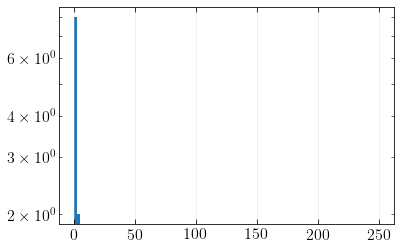

In [10]:
results = llh.do_trials(10, src_ra=ra, src_dec=dec)
plt.hist(results['TS'], bins=np.linspace(0., 250, 101))
plt.yscale('log')
plt.show()

In [11]:
results

array([(0, 0.        ,   0.        , 2.5),
       (0, 1.5688387 ,  83.46626002, 2.5),
       (0, 0.        ,   0.        , 2.5),
       (0, 0.74215129,  52.30333294, 2.5),
       (0, 4.53813293, 157.23806529, 2.5),
       (0, 1.53376903,  86.3755373 , 2.5),
       (0, 0.64164266,  48.26643141, 2.5),
       (0, 3.57434214, 139.56155216, 2.5),
       (0, 0.47799913,  47.4742726 , 2.5),
       (0, 0.36612087,  40.57830386, 2.5)],
      dtype=[('n_inj', '<i8'), ('TS', '<f8'), ('nsignal', '<f8'), ('gamma', '<f8')])

In [37]:
sorted(llh.llh_model._w_spline_dict.keys())[0][0][1]

0.9

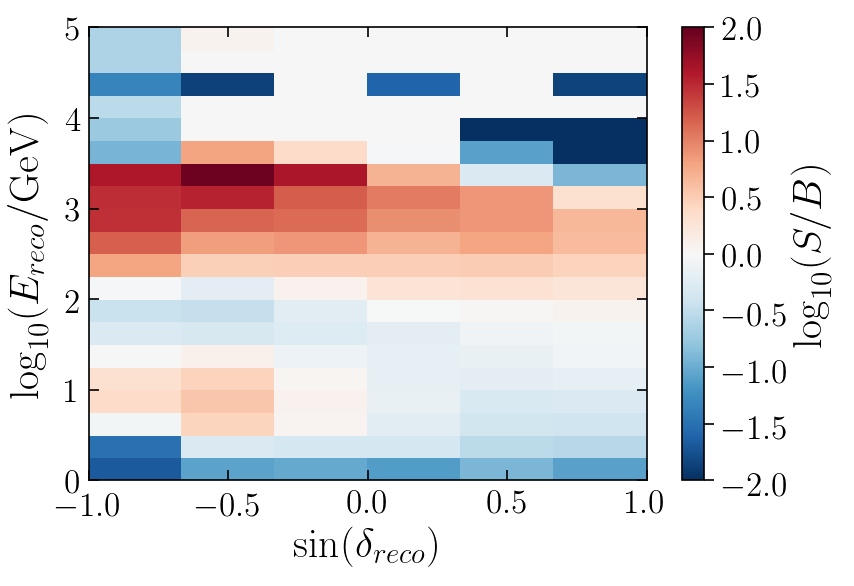

In [12]:
fig, ax = plt.subplots(dpi=150, figsize = (6,4))
fig.set_facecolor('w')
decs = sinDec_bins[:-1] + (np.diff(sinDec_bins) / 2.)
es = energy_bins[:-1] + (np.diff(energy_bins) / 2.)

e_plot = [e for e in es for dec in decs]
dec_plot = [dec for e in es for dec in decs]
H = np.array([llh.llh_model._w_spline_dict[llh.llh_model._w_spline_dict.keys()[0]]([e,dec])[0] for e in es for dec in decs])

n, energy_spline_bins, sinDec_spline_bins = np.histogram2d(e_plot, dec_plot, bins=[energy_bins, sinDec_bins], 
                                                  weights = H)

X, Y = np.meshgrid(sinDec_spline_bins, energy_spline_bins)
cax = plt.pcolormesh(X, Y, n, cmap = plt.cm.RdBu_r, shading='gourard', vmin=-2, vmax=2)
cbar = plt.colorbar()
cbar.set_label(r'$\log_{10} (S / B)$', fontsize = 20)
cbar.ax.tick_params(axis='y', direction='out')
plt.ylim(0.,5.)
plt.xlabel(r'$\sin ( \delta_{reco})$', fontsize = 20)
plt.ylabel(r'$\log_{10} (E_{reco} / \mathrm{GeV})$', fontsize = 20)
plt.show()

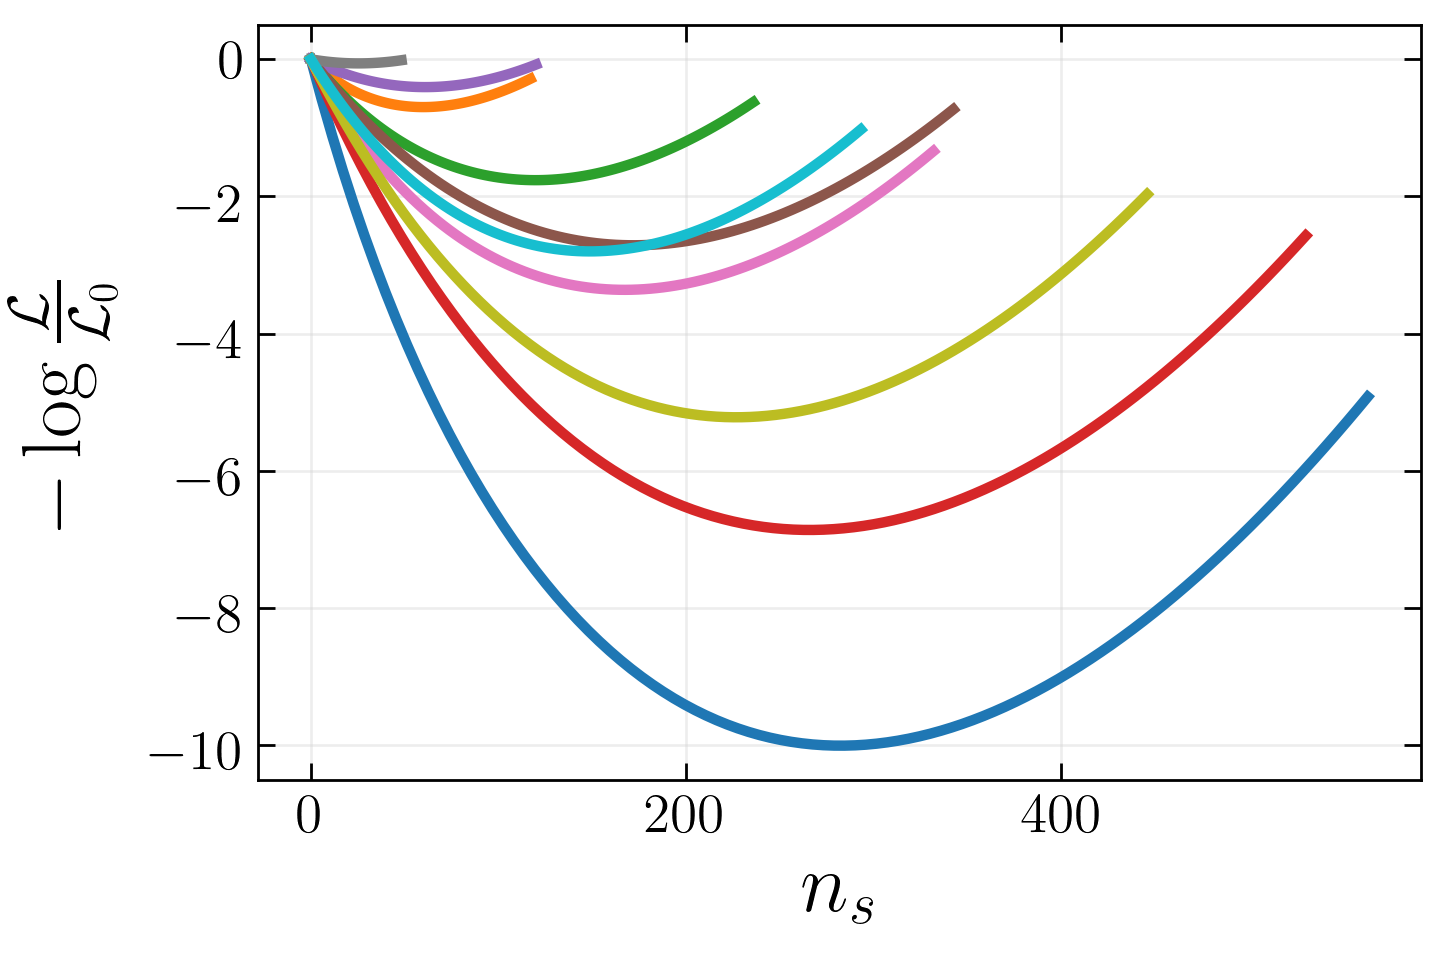

In [32]:
params = {'gamma': 2.5}
fig, ax = plt.subplots(dpi=250)
for i in range(10):
    ts, ns = llh.fit_source(src_ra=ra, src_dec=dec, scramble=True)
    xs = np.linspace(0., 2*ns['nsignal'], 100)
    llhs = []
    for n in xs:
        llhs.append(llh.llh(n, **params)[0])
    llhs = np.array(llhs)
    plt.plot(xs[:len(llhs)], -llhs, lw = 3)
    #plt.axvline(ns, ls = '--', color = 'gray', lw = 1)
    plt.xlabel(r'$n_s$', fontsize = 24)
    plt.ylabel(r'$-\log \frac{\mathcal{L}}{\mathcal{L}_0}$', fontsize = 24)
plt.show()

In [ ]:
results = llh.do_trials(500, src_ra=ra, src_dec=dec)

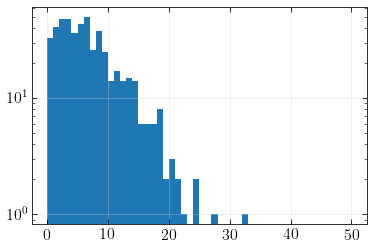

In [31]:
plt.hist(results['TS'], bins=np.linspace(0., 50, 51))
plt.yscale('log')
plt.show()